## Setup

In [1]:
import torch
import numpy as np
import random
import os

print(torch.__version__)

def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


1.13.0


/raid/nlp/tejomoy/anaconda3/envs/graph/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Ingestion

In [2]:
import pandas as pd

user_path = "/raid/nlp/tejomoy/graphML/KP-GNN-Kishan/data/movielens/users.csv"
movies_path = "/raid/nlp/tejomoy/graphML/KP-GNN-Kishan//data/movielens/movies.csv"
ratings_path = "/raid/nlp/tejomoy/graphML/KP-GNN-Kishan//data/movielens/ratings.csv"

In [3]:
ratings_df = pd.read_csv(ratings_path)[["userId", "movieId", "rating"]]
users_df = pd.read_csv(user_path)[['user_id', 'Gender', 'Age', 'occupation', 'Pin Code']]


ratings_df['rating_og'] = ratings_df['rating']
ratings_df['rating'] = ratings_df['rating']

movies_df = pd.read_csv(movies_path, index_col='movieId')

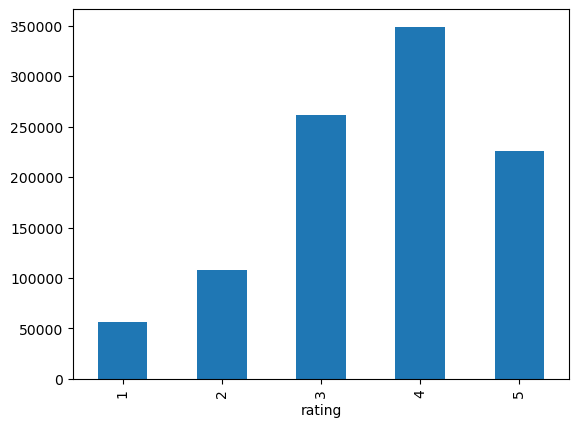

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
rating_count = ratings_df.sort_values(['rating'], ascending=False)['rating'].value_counts()
rating_count.sort_index().plot(ax=ax, kind='bar')

#### User Features

In [5]:
age_features = users_df['Age'].str.get_dummies().values
age_features = torch.from_numpy(age_features)#.to(torch.int64)

gender_features = users_df['Gender'].str.get_dummies().values
gender_features = torch.from_numpy(gender_features)#.to(torch.int64)

occ_features = users_df['occupation'].str.get_dummies().values
occ_features = torch.from_numpy(occ_features)#.to(torch.int64)

address_features = users_df['Pin Code'].str.get_dummies().values
address_features = torch.from_numpy(address_features)#.to(torch.int64)


In [6]:
user_peripheral_info = torch.cat([age_features, gender_features, occ_features, address_features], dim=-1)

In [7]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# One-hot encode the genres:
genres = movies_df['genres'].str.get_dummies('|').values
genres = torch.from_numpy(genres).to(torch.float)

# Load the pre-trained sentence transformer model and encode the movie titles:
model = SentenceTransformer('all-MiniLM-L6-v2')
with torch.no_grad():
    titles = model.encode(movies_df['title'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    titles = titles.cpu()

# Concatenate the genres and title features:
movie_features = torch.cat([genres, titles], dim=-1)

# We don't have user features, which is why we use an identity matrix
user_features = torch.eye(len(ratings_df['userId'].unique()))


Batches: 100%|██████████| 122/122 [00:03<00:00, 37.44it/s]


In [8]:
# Create a mapping from the userId to a unique consecutive value in the range [0, num_users]:
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedUserId': pd.RangeIndex(len(unique_user_id))
    })

# Create a mapping from the movieId to a unique consecutive value in the range [0, num_movies]:
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedMovieId': pd.RangeIndex(len(unique_movie_id))
    })

# Merge the mappings with the original data frame:
ratings_df = ratings_df.merge(unique_user_id, on='userId')
ratings_df = ratings_df.merge(unique_movie_id, on='movieId')

edge_index = torch.stack([
    torch.tensor(ratings_df['mappedUserId'].values),
    torch.tensor(ratings_df['mappedMovieId'].values)]
    , dim=0)

assert edge_index.shape == (2, len(ratings_df))

In [9]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

data = HeteroData()

data['user'].x = user_features  # [num_users, num_features_users]
data['movie'].x = movie_features  # [num_movies, num_features_movies]

data['user'].pe_attr = user_peripheral_info  # [num_user, num_features_users]

data['user', 'rates', 'movie'].edge_index = edge_index  # [2, num_ratings]

rating = torch.from_numpy(ratings_df['rating'].values).to(torch.float)
data['user', 'rates', 'movie'].edge_label = rating  # [num_ratings]

data = T.ToUndirected()(data)

# With the ToUndirected() we also got reversed labels for the edges.
# We are going to remove them:
del data['movie', 'rev_rates', 'user'].edge_label
print(data['movie'].num_features)
assert data['user'].num_nodes == len(unique_user_id)
assert data['user', 'rates', 'movie'].num_edges == len(ratings_df)
assert data['movie'].num_features == 402


402


## Dataset Splitting


In [10]:
data["user", "rates", "movie"]['edge_attr'] = data["user", "rates", "movie"]['edge_label']
data["user", "rates", "movie"]['x_dict'] = data.x_dict
data["user", "rates", "movie"]['user_features'] = data["user"]['pe_attr']
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)
train_data, val_data

(HeteroData(
   user={
     x=[6040, 6040],
     pe_attr=[6040, 3469],
   },
   movie={ x=[3883, 402] },
   (user, rates, movie)={
     edge_index=[2, 800169],
     edge_attr=[800169],
     x_dict={
       user=[6040, 6040],
       movie=[3883, 402],
     },
     user_features=[6040, 3469],
     edge_label=[800169],
     edge_label_index=[2, 800169],
   },
   (movie, rev_rates, user)={ edge_index=[2, 800169] }
 ),
 HeteroData(
   user={
     x=[6040, 6040],
     pe_attr=[6040, 3469],
   },
   movie={ x=[3883, 402] },
   (user, rates, movie)={
     edge_index=[2, 800169],
     edge_attr=[800169],
     x_dict={
       user=[6040, 6040],
       movie=[3883, 402],
     },
     user_features=[6040, 3469],
     edge_label=[100020],
     edge_label_index=[2, 100020],
   },
   (movie, rev_rates, user)={ edge_index=[2, 800169] }
 ))

## Evaluation Function

In [11]:
from tqdm import tqdm


def hit_rate_top_k(k, predicted_df, threshold=28):
    uids = list(set(predicted_df['userId']))

    intersection_count = []
    for i in tqdm(range(len(uids))):

        # extract top_k movies according to predicted and target rating 
        top_k_predicted = predicted_df[predicted_df['userId']==uids[i]].sort_values(['rating'], ascending=False)['movieId'][:k]
        top_k_target = predicted_df[predicted_df['userId']==uids[i]].sort_values(['target'], ascending=False)['movieId'][:threshold]
        
        # calculate the intersection of predicted and target set
        common_set = (set(top_k_predicted) & set(top_k_target))

        # stores intersection of every user id
        intersection_count.append(common_set)


    # Average intersection
    average_overlap = sum([len(x) for x in intersection_count])/len(intersection_count)
    
    # percentage of average overlap
    top_k_hit = (average_overlap/k)*100

    return top_k_hit

In [12]:
from layers import layer_utils
from models import model_utils
from layers.input_encoder import LinearEncoder


def get_model(args):
    layer = layer_utils.make_gnn_layer(args)
    init_emb = LinearEncoder(args.input_size, args.hidden_size)
    GNNModel = model_utils.make_GNN(args)
    gnn = GNNModel(
        num_layer=args.num_layer,
        gnn_layer=layer,
        JK=args.JK,
        norm_type=args.norm_type,
        init_emb=init_emb,
        residual=args.residual,
        virtual_node=args.virtual_node,
        use_rd=args.use_rd,
        num_hop1_edge=args.num_hop1_edge,
        max_edge_count=args.max_edge_count,
        max_hop_num=args.max_hop_num,
        max_distance_count=args.max_distance_count,
        wo_peripheral_edge=args.wo_peripheral_edge,
        wo_peripheral_configuration=args.wo_peripheral_configuration,
        drop_prob=args.drop_prob)

    return gnn

In [13]:

class args:
        JK="last"
        K = 1
        MODULO= 4
        MOD_THRESH= 1
        aggr= "sum"
        batch_size= 128
        combine= "geometric"
        drop_prob= 0.0
        eps= 0.0
        gpu_ids= [0, 1]
        hidden_size= 48
        input_size= 48
        kernel= "spd"
        l2_wd= 3e-07
        load_path= ""
        lr= 0.001
        max_distance_count= 1000
        max_edge_count= 1000
        max_edge_type= 1
        max_hop_num= 5
        max_pe_num= 1
        model_name= "KPGIN" #"KPGraphSAGE", "KPGINPlus", "KPGIN"
        norm_type= "Batch"
        num_epochs= 40
        num_hop1_edge= 1
        num_hopk_edge= 1
        num_layer= 3
        num_workers= 0
        output_size= 2
        parallel= False
        pooling_method= "sum"
        reprocess= True
        residual= False
        seed= 224
        split= 10
        train_eps= False
        use_rd= False
        virtual_node= False
        wo_edge_feature= False
        wo_path_encoding= False
        wo_peripheral_configuration= False
        wo_peripheral_edge= False
        epochs = 500

In [14]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [15]:
#maps user features and movie features to a same dimensional embedding space
class InitUserMovieEmb(torch.nn.Module):
    def __init__(self, user_input_size, movie_input_size, output_size):
        super().__init__()
        self.user_linear_encoder = torch.nn.Linear(user_input_size, output_size)
        self.movie_linear_encoder = torch.nn.Linear(movie_input_size, output_size)
    
    def forward(self, user_x, movie_x):
        user_emb = self.user_linear_encoder(user_x)
        movie_emb = self.movie_linear_encoder(movie_x)
        embs = torch.cat([user_emb, movie_emb], dim=0)
        return embs, user_emb.size(0)

# same as above but for peripheral graph
class Peripheral_Emb(torch.nn.Module):
    def __init__(self, user_input_size, movie_input_size, output_size):
        super().__init__()
        self.user_linear_encoder = torch.nn.Linear(user_input_size, output_size)
        self.movie_linear_encoder = torch.nn.Linear(movie_input_size, output_size)
    
    def forward(self, user_x, movie_x):
        user_emb = self.user_linear_encoder(user_x.to(torch.float32))
        movie_emb = self.movie_linear_encoder(movie_x)
        embs = torch.cat([user_emb, movie_emb], dim=0)
        return embs, user_emb.size(0)

# given two node embeddings, determines the rating 
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, user_dict, movies_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([user_dict[row], movies_dict[col]], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.init_peripheral = Peripheral_Emb(user_input_size=user_peripheral_info.size(1), 
                                              movie_input_size=movie_features.size(1), 
                                              output_size=args.hidden_size)
        
        self.init_user_movie_emb = InitUserMovieEmb(user_input_size=user_features.size(1),
                                                    movie_input_size=movie_features.size(1), 
                                                    output_size=args.hidden_size)

        self.encoder = get_model(args)
        
        self.decoder = EdgeDecoder(hidden_channels=args.hidden_size)
        print("---------------------------------")
        print("K: ",args.K)
        print("Kernel: ", args.kernel)
        print("Model Name: ", args.model_name)
        print("---------------------------------")


    def forward(self, data, edge_label_index):
        node_embs, split_index = self.init_user_movie_emb(data.x_dict['user'], data.x_dict['movie'])
        peri_embs, _peri_split_index = self.init_peripheral(data['user_features'], data.x_dict['movie'])
        data['x'] = node_embs
        data['pe_attr'] = peri_embs
        z_dict = self.encoder(data)
        user_dict, movies_dict = torch.split(z_dict, [split_index, node_embs.size(0) - split_index], dim=0) # To split user and movie embeddings
        return self.decoder(user_dict, movies_dict, edge_label_index)

In [16]:
from itertools import product

args.epochs = 500
k_range = [1, 2, 3]
kernel_set = ["spd", "gd"]
variations = list(product(set(k_range),set(kernel_set)))

## Experiments

In [29]:
## KPGIN
import torch.nn.functional as F

for k, kernel in variations:
    args.K = k
    args.kernel = kernel
    model = Model(hidden_channels=32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    def train(loss_type="mse"):
        model.train()
        optimizer.zero_grad()
        splitted_data = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')],
    )(data)
        pred = model(train_data["user", "rates", "movie"], train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        if loss_type =="mse":
            loss = F.mse_loss(pred, target)
        elif loss_type == "BPR":
            loss = F.mse_loss(pred, target)
    
        loss.backward()
        optimizer.step()
        return float(loss)
    
    
    @torch.no_grad()
    def test(data):
        data = data.to(device)
        model.eval()
        pred = model(data["user", "rates", "movie"],
                     data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)
    
    # ep = 500
    # for i in [1]:
    #     model = get_model__()
    for epoch in range(1, args.epochs+1):
        train_data = train_data.to(device)
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}')
    with torch.no_grad():
        test_data = test_data.to(device)
        pred = model(test_data["user", "rates", "movie"],
                     test_data['user', 'movie'].edge_label_index)
        
        # pred = model(test_data.x_dict, test_data.edge_index_dict,
        #              test_data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = test_data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        print(f'Test RMSE: {rmse:.4f}')

    userId = test_data['user', 'movie'].edge_label_index[0].cpu().numpy()
    movieId = test_data['user', 'movie'].edge_label_index[1].cpu().numpy()
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    predicted_df = pd.DataFrame({'userId': userId, 'movieId': movieId, 'rating': pred, 'target': target})
    
    print(predicted_df.describe())
    
    print(hit_rate_top_k(k=10, predicted_df=predicted_df))

    print("-------------------------------------------------"*10)
    print("-------------------------------------------------"*10)



---------------------------------
K:  1
Kernel:  gd
Model Name:  KPGIN
---------------------------------
Epoch: 001, Loss: 14.8744, Train: 3.1692, Val: 3.1714
Epoch: 002, Loss: 12.4428, Train: 2.7895, Val: 2.7926
Epoch: 003, Loss: 9.1875, Train: 2.5537, Val: 2.5546
Epoch: 004, Loss: 5.4625, Train: 2.2138, Val: 2.2128
Epoch: 005, Loss: 3.2286, Train: 1.7473, Val: 1.7431
Epoch: 006, Loss: 3.3760, Train: 1.5694, Val: 1.5632
Epoch: 007, Loss: 2.5965, Train: 1.5194, Val: 1.5136
Epoch: 008, Loss: 2.0711, Train: 1.5076, Val: 1.5035
Epoch: 009, Loss: 1.7724, Train: 1.4965, Val: 1.4942
Epoch: 010, Loss: 1.7367, Train: 1.4867, Val: 1.4816
Epoch: 011, Loss: 1.5297, Train: 1.4989, Val: 1.4936
Epoch: 012, Loss: 1.5209, Train: 1.5087, Val: 1.5037
Epoch: 013, Loss: 1.4164, Train: 1.5235, Val: 1.5187
Epoch: 014, Loss: 1.3999, Train: 1.5291, Val: 1.5245
Epoch: 015, Loss: 1.3961, Train: 1.5258, Val: 1.5213
Epoch: 016, Loss: 1.3781, Train: 1.5151, Val: 1.5105
Epoch: 017, Loss: 1.3478, Train: 1.5004, Val:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1092.08it/s]


69.85740647542357
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1090.98it/s]


69.89095789297097
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1097.41it/s]


70.0167757087737
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1094.41it/s]


70.21137393054858
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1042.99it/s]


70.21137393054858
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1093.24it/s]

70.30699547055863
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
## KPGraphSAGE
args.model_name = "KPGraphSAGE"
import torch.nn.functional as F

for k, kernel in variations:
    args.K = k
    args.kernel = kernel
    model = Model(hidden_channels=32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    def train(loss_type="mse"):
        model.train()
        optimizer.zero_grad()
        splitted_data = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')],
    )(data)
        pred = model(train_data["user", "rates", "movie"], train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        if loss_type =="mse":
            loss = F.mse_loss(pred, target)
        elif loss_type == "BPR":
            loss = F.mse_loss(pred, target)
    
        loss.backward()
        optimizer.step()
        return float(loss)
    
    
    @torch.no_grad()
    def test(data):
        data = data.to(device)
        model.eval()
        pred = model(data["user", "rates", "movie"],
                     data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)
    
    # ep = 500
    # for i in [1]:
    #     model = get_model__()
    for epoch in range(1, args.epochs+1):
        train_data = train_data.to(device)
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}')
    with torch.no_grad():
        test_data = test_data.to(device)
        pred = model(test_data["user", "rates", "movie"],
                     test_data['user', 'movie'].edge_label_index)
        
        # pred = model(test_data.x_dict, test_data.edge_index_dict,
        #              test_data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = test_data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        print(f'Test RMSE: {rmse:.4f}')

    userId = test_data['user', 'movie'].edge_label_index[0].cpu().numpy()
    movieId = test_data['user', 'movie'].edge_label_index[1].cpu().numpy()
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    predicted_df = pd.DataFrame({'userId': userId, 'movieId': movieId, 'rating': pred, 'target': target})
    
    print(predicted_df.describe())
    
    print(hit_rate_top_k(k=10, predicted_df=predicted_df))

    print("-------------------------------------------------"*10)
    print("-------------------------------------------------"*10)



---------------------------------
K:  1
Kernel:  gd
Model Name:  KPGraphSAGE
---------------------------------
Epoch: 001, Loss: 13.9511, Train: 3.6618, Val: 3.6646
Epoch: 002, Loss: 9.6557, Train: 3.4709, Val: 3.4738
Epoch: 003, Loss: 3.3306, Train: 3.1450, Val: 3.1478
Epoch: 004, Loss: 1.6042, Train: 2.9102, Val: 2.9131
Epoch: 005, Loss: 2.8506, Train: 2.8992, Val: 2.9019
Epoch: 006, Loss: 1.3729, Train: 2.9302, Val: 2.9328
Epoch: 007, Loss: 1.5366, Train: 2.9162, Val: 2.9188
Epoch: 008, Loss: 1.4247, Train: 2.8571, Val: 2.8596
Epoch: 009, Loss: 1.2482, Train: 2.7896, Val: 2.7921
Epoch: 010, Loss: 1.3278, Train: 2.7727, Val: 2.7752
Epoch: 011, Loss: 1.3337, Train: 2.8036, Val: 2.8061
Epoch: 012, Loss: 1.2289, Train: 2.8383, Val: 2.8409
Epoch: 013, Loss: 1.2615, Train: 2.8409, Val: 2.8436
Epoch: 014, Loss: 1.2963, Train: 2.7993, Val: 2.8020
Epoch: 015, Loss: 1.2293, Train: 2.7326, Val: 2.7353
Epoch: 016, Loss: 1.2185, Train: 2.6787, Val: 2.6814
Epoch: 017, Loss: 1.2508, Train: 2.6607,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1095.88it/s]


70.36738802214393
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1092.39it/s]


70.3036403288039
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1043.28it/s]


70.03355141754739
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1080.06it/s]


70.30699547055863
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1012.14it/s]


70.04193927193424
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1039.15it/s]

70.29860761617178
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [25]:
## KPGINplus
args.model_name = "KPGINPlus"
import torch.nn.functional as F

for k, kernel in variations:
    args.K = k
    args.kernel = kernel
    model = Model(hidden_channels=32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    def train(loss_type="mse"):
        model.train()
        optimizer.zero_grad()
        splitted_data = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')],
    )(data)
        pred = model(train_data["user", "rates", "movie"], train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        if loss_type =="mse":
            loss = F.mse_loss(pred, target)
        elif loss_type == "BPR":
            loss = F.mse_loss(pred, target)
    
        loss.backward()
        optimizer.step()
        return float(loss)
    
    
    @torch.no_grad()
    def test(data):
        data = data.to(device)
        model.eval()
        pred = model(data["user", "rates", "movie"],
                     data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)
    
    # ep = 500
    # for i in [1]:
    #     model = get_model__()
    for epoch in range(1, args.epochs+1):
        train_data = train_data.to(device)
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}')
    with torch.no_grad():
        test_data = test_data.to(device)
        pred = model(test_data["user", "rates", "movie"],
                     test_data['user', 'movie'].edge_label_index)
        
        # pred = model(test_data.x_dict, test_data.edge_index_dict,
        #              test_data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = test_data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        print(f'Test RMSE: {rmse:.4f}')

    userId = test_data['user', 'movie'].edge_label_index[0].cpu().numpy()
    movieId = test_data['user', 'movie'].edge_label_index[1].cpu().numpy()
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    predicted_df = pd.DataFrame({'userId': userId, 'movieId': movieId, 'rating': pred, 'target': target})
    
    print(predicted_df.describe())
    
    print(hit_rate_top_k(k=10, predicted_df=predicted_df))

    print("-------------------------------------------------"*10)
    print("-------------------------------------------------"*10)



---------------------------------
K:  1
Kernel:  gd
Model Name:  KPGINPlus
---------------------------------
Epoch: 001, Loss: 13.9445, Train: 2.7917, Val: 2.7940
Epoch: 002, Loss: 11.5519, Train: 2.7623, Val: 2.7657
Epoch: 003, Loss: 9.3448, Train: 2.5980, Val: 2.6005
Epoch: 004, Loss: 6.8528, Train: 2.3546, Val: 2.3556
Epoch: 005, Loss: 3.9333, Train: 1.9845, Val: 1.9836
Epoch: 006, Loss: 2.0399, Train: 1.6997, Val: 1.6980
Epoch: 007, Loss: 2.0187, Train: 1.5629, Val: 1.5605
Epoch: 008, Loss: 1.9424, Train: 1.4834, Val: 1.4808
Epoch: 009, Loss: 1.4696, Train: 1.4384, Val: 1.4358
Epoch: 010, Loss: 1.3670, Train: 1.4232, Val: 1.4201
Epoch: 011, Loss: 1.4433, Train: 1.4160, Val: 1.4129
Epoch: 012, Loss: 1.6142, Train: 1.4148, Val: 1.4116
Epoch: 013, Loss: 1.4122, Train: 1.4069, Val: 1.4040
Epoch: 014, Loss: 1.3987, Train: 1.3925, Val: 1.3901
Epoch: 015, Loss: 1.3289, Train: 1.3839, Val: 1.3818
Epoch: 016, Loss: 1.3187, Train: 1.3769, Val: 1.3748
Epoch: 017, Loss: 1.3042, Train: 1.3630, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:06<00:00, 960.25it/s]


67.80909243415533
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1007.52it/s]


67.80909243415533
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1032.35it/s]


67.80909243415533
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1099.16it/s]


67.80909243415533
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1143.05it/s]


67.80909243415533
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5961/5961 [00:05<00:00, 1123.01it/s]

67.80909243415533
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### Analysis 

In [62]:
!cat results/KPGINPlus.txt  | grep K:

K:  1
K:  1
K:  2
K:  2
K:  3
K:  3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [61]:
!cat results/KPGINPlus.txt | grep Kernel

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Kernel:  gd
Kernel:  spd
Kernel:  gd
Kernel:  spd
Kernel:  gd
Kernel:  spd


In [60]:
!cat results/KPGINPlus.txt  | grep min | awk '{print $4}'

2.866282
2.046153
2.175252
2.114229
1.966760
2.382774


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [59]:
!cat results/KPGINPlus.txt  | grep max | awk '{print $4}'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


5.000000
5.000000
4.782679
4.737682
5.000000
4.048375


In [58]:
!cat results/KPGINPlus.txt  | grep std | awk '{print $4}'

0.402697
0.258405
0.325537
0.257493
0.335514
0.195963


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
!cat results/KPGINPlus.txt | grep mean | awk '{print $4}'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


4.254896
3.551714
3.453632
3.653458
3.560501
3.364030
